# Word2Vec on the Akkadian ORACC corpus

This lesson is designed to explore features of word embeddings produced through the word2vec model.

The primary corpus we use consists of [Akkadian ORACC corpus](https://github.com/niekveldhuis/Word2vec), put together by Professor Niek Veldhuis, UC Berkeley Near Eastern Studies.

At then end we'll also look at a <a href="http://ryanheuser.org/word-vectors-1/">Word2Vec model trained on the ECCO-TCP corpus</a> of 2,350 eighteenth-century literary texts made available by Ryan Heuser. (Note that I have shortened the number of terms in the model by half in order to conserve memory.)

### Learning Goals
* Learn the intuition behind word embedding models (WEM)
* Learn how to implement a WEM using the gensim implementation of word2vec
* Explore a completely unknown corpus using this method (unknown to most of you)
* Think through how visualization of WEM might help you explore your corpus
* Implement text analysis on a non-English language

### Agenda
<ol>
<li>Import & Pre-Processing</li>
<li>Word2Vec</li>
<ol><li>Training</li>
<li>Embeddings</li>
<li>Visualization</li>
</ol>
<li>Saving/Loading Models</li>
</ol>

### Further Resources

For further background on Word2Vec's mechanics, I suggest this <a href="https://www.tensorflow.org/versions/r0.8/tutorials/word2vec/index.html">brief tutorial</a> by Google, especially the sections "Motivation," "Skip-Gram Model," and "Visualizing."

Ben Schmidt's blogs [here](http://bookworm.benschmidt.org/posts/2015-10-25-Word-Embeddings.html) and [here](http://bookworm.benschmidt.org/posts/2015-10-30-rejecting-the-gender-binary.html).

## 0. Prep

Install a new package, and import necessary packages.

In [1]:
#Install a package that is not in the Anaconda distribution
#To do this we'll use pip install
!pip3 install gensim

In [2]:
#import the necessary libraries

#Data Wrangling
import pandas
import numpy as np
import os

import gensim #library needed for word2vec

#for visualization
from scipy.spatial.distance import cosine
from sklearn.metrics import pairwise
from sklearn.manifold import MDS, TSNE

In [3]:
#Visualization parameters
%pylab inline
matplotlib.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


## 1. Import and Pre-Processing

### Corpus Description

The corus description can be found [here](https://github.com/niekveldhuis/Word2vec).

### Import Data

Read in all of the .csv files in the folder `../data/oracc/`, do some pre-processing on it, and concat them all into a Pandas dataframe

In [4]:
#read in all the data, with some cleaning
#I won't explain this code, but challenge yourself to understand it
path ='../data/oracc/' # indicate the local path where files are stored
allFiles = os.listdir(path) #save the list of filenames into a variable
print(allFiles)

['rinap_rinap4.csv', 'ribo_babylon4.csv', 'ribo_babylon10.csv', 'cams_gkab.csv', 'rinap_rinap5.csv', 'saao.csv', 'cmawro.csv', 'ribo_babylon8.csv', 'cams_anzu.csv', 'glass.csv', 'rinap_rinap1.csv', 'dcclt.csv', 'riao.csv', 'dcclt_nineveh.csv', 'ccpo.csv', 'hbtin.csv', 'ribo_babylon7.csv', 'blms.csv', 'rinap_rinap3.csv', 'aemw_amarna.csv', 'ribo_babylon2.csv', 'ribo_babylon5.csv', 'ribo_babylon6.csv', 'ribo_babylon3.csv', 'suhu.csv']


In [5]:
list_ = []
files_ = []
for file_ in allFiles:
    filename = path+file_ #add the relative path name to the filename
    df = pandas.read_csv(filename,index_col=None, header=0)
    df['id_text'] = [file_[7:-4].replace('_', '/') + '/' + text for text in df['id_text']]
    df['lemma'] = [lemma.replace('$', '') for lemma in df['lemma']]
    list_.append(df)
    files_.append(file_[7:-4].replace('_', '/'))
data = pandas.concat(list_).reset_index(drop=True)
#view the data
data

,id_text,lemma
0,inap4/Q003230,ēkallu[palace]N Aššur-ahu-iddina[Esarhaddon-ki...
1,inap4/Q003231,ēkallu[palace]N Aššur-ahu-iddina[Esarhaddon-ki...
2,inap4/Q003232,x[NA]NA x[NA]NA x[NA]NA x[NA]NA x[NA]NA x[NA]N...
3,inap4/Q003233,x[NA]NA kamîš[in-a-bound-state]AV u[and]CNJ Te...
4,inap4/Q003234,ša[that]REL ahu[brother]N rabû[great]AJ ahu[br...
5,inap4/Q003235,x[NA]NA x[NA]NA x[NA]NA x[NA]NA x[NA]NA ṣarāhu...
6,inap4/Q003236,u[and]CNJ ummānu[military-force]N Išpakaia[chi...
7,inap4/Q003237,x[NA]NA x[NA]NA x[NA]NA x[NA]NA x[NA]NA šūt[wh...
8,inap4/Q003238,x[NA]NA kayyānu[constant]AJ x[NA]NA x[NA]NA ag...
9,inap4/Q003239,Aššur-ahu-iddina[Esarhaddon-king-of-Assyria]RN...


In [6]:
#Number of rows
data.shape

(7630, 2)

In [7]:
#View the first text
data.iloc[0,1]

"ēkallu[palace]N Aššur-ahu-iddina[Esarhaddon-king-of-Assyria]RN šarru[king]N rabû[great]AJ šarru[king]N dannu[strong]AJ šarru[king]N kiššatu[totality]N šarru[king]N mātu[land]N Aššur[Assyria]GN šakkanakku[(military)-governor]N Babili[Babylon]SN šarru[king]N mātu[land]N Šumeru[Sumer]GN u[and]CNJ Akkad[1]GN šarru[king]N kibru[bank]N erbe[four]NU rēʾû[shepherd]N kīnu[permanent]AJ migru[consent]N ilu[god]N rabû[great]AJ ša[that]REL ištu[from]PRP ṣehru[(time-of)-youth]N Aššur[1]DN Šamaš[1]DN Bel[1]DN u[and]CNJ Nabu[1]DN Ištar[1]DN ša[of]DET Ninua[Nineveh]SN Ištar[1]DN ša[of]DET Arba-il[Arbela]SN ana[to]PRP šarrūtu[kingship]N mātu[land]N Aššur[Assyria]GN nabû[name]V zikru[utterance]N ša[that]REL ahu[brother]N rabû[great]AJ ahu[brother]N ṣehru[small]AJ anāku[I]IP ina[in]PRP qibītu[speech]N Aššur[1]DN Sin[1]DN Šamaš[1]DN Bel[1]DN u[and]CNJ Nabu[1]DN Ištar[1]DN ša[of]DET Ninua[Nineveh]SN Ištar[1]DN ša[of]DET Arba-il[Arbela]SN abu[father]N bānû[creator]N ina[in]PRP puhru[assembly]N ahu[brother]N

### Pre-Processing

Word2Vec learns about the relationships among words by observing them in context. This means that we want to split our texts into word-units. In this text there is no punctuation, and thus nothing resembling a sentence. In other text we  want to maintain sentence boundaries as well, since the last word of the previous sentence might skew the meaning of the next sentence.

You can split your text in sentences using ` nltk.tokenize.sent_tokenize()`

For today, we'll tokenize our text by spliting on the white space.

In [8]:
#tokenize the data by splitting on white space. There is no punctuation in this text.
data['tokens'] = data['lemma'].str.split()
data['tokens'][0]

['ēkallu[palace]N',
 'Aššur-ahu-iddina[Esarhaddon-king-of-Assyria]RN',
 'šarru[king]N',
 'rabû[great]AJ',
 'šarru[king]N',
 'dannu[strong]AJ',
 'šarru[king]N',
 'kiššatu[totality]N',
 'šarru[king]N',
 'mātu[land]N',
 'Aššur[Assyria]GN',
 'šakkanakku[(military)-governor]N',
 'Babili[Babylon]SN',
 'šarru[king]N',
 'mātu[land]N',
 'Šumeru[Sumer]GN',
 'u[and]CNJ',
 'Akkad[1]GN',
 'šarru[king]N',
 'kibru[bank]N',
 'erbe[four]NU',
 'rēʾû[shepherd]N',
 'kīnu[permanent]AJ',
 'migru[consent]N',
 'ilu[god]N',
 'rabû[great]AJ',
 'ša[that]REL',
 'ištu[from]PRP',
 'ṣehru[(time-of)-youth]N',
 'Aššur[1]DN',
 'Šamaš[1]DN',
 'Bel[1]DN',
 'u[and]CNJ',
 'Nabu[1]DN',
 'Ištar[1]DN',
 'ša[of]DET',
 'Ninua[Nineveh]SN',
 'Ištar[1]DN',
 'ša[of]DET',
 'Arba-il[Arbela]SN',
 'ana[to]PRP',
 'šarrūtu[kingship]N',
 'mātu[land]N',
 'Aššur[Assyria]GN',
 'nabû[name]V',
 'zikru[utterance]N',
 'ša[that]REL',
 'ahu[brother]N',
 'rabû[great]AJ',
 'ahu[brother]N',
 'ṣehru[small]AJ',
 'anāku[I]IP',
 'ina[in]PRP',
 'qibītu[sp

### Data Cleaning
Unlemmatized (broken or unknown) words are represented as, for instance, `x-ši-ka[NA]NA`. Such tokens are essentially placeholders. One may try two different approaches:
- represent all such placeholders by NA
- eliminate all placeholders

In [9]:
data_NA = data.copy()
data_NA['tokens'] = data_NA['tokens'].apply(lambda x: [token if not token.endswith('NA]NA') else 'NA' for token in x])

In [10]:
data['tokens'] = data['tokens'].apply(lambda x: [token for token in x if not token.endswith('NA]NA')])

In [11]:
data['tokens'][0]

['ēkallu[palace]N',
 'Aššur-ahu-iddina[Esarhaddon-king-of-Assyria]RN',
 'šarru[king]N',
 'rabû[great]AJ',
 'šarru[king]N',
 'dannu[strong]AJ',
 'šarru[king]N',
 'kiššatu[totality]N',
 'šarru[king]N',
 'mātu[land]N',
 'Aššur[Assyria]GN',
 'šakkanakku[(military)-governor]N',
 'Babili[Babylon]SN',
 'šarru[king]N',
 'mātu[land]N',
 'Šumeru[Sumer]GN',
 'u[and]CNJ',
 'Akkad[1]GN',
 'šarru[king]N',
 'kibru[bank]N',
 'erbe[four]NU',
 'rēʾû[shepherd]N',
 'kīnu[permanent]AJ',
 'migru[consent]N',
 'ilu[god]N',
 'rabû[great]AJ',
 'ša[that]REL',
 'ištu[from]PRP',
 'ṣehru[(time-of)-youth]N',
 'Aššur[1]DN',
 'Šamaš[1]DN',
 'Bel[1]DN',
 'u[and]CNJ',
 'Nabu[1]DN',
 'Ištar[1]DN',
 'ša[of]DET',
 'Ninua[Nineveh]SN',
 'Ištar[1]DN',
 'ša[of]DET',
 'Arba-il[Arbela]SN',
 'ana[to]PRP',
 'šarrūtu[kingship]N',
 'mātu[land]N',
 'Aššur[Assyria]GN',
 'nabû[name]V',
 'zikru[utterance]N',
 'ša[that]REL',
 'ahu[brother]N',
 'rabû[great]AJ',
 'ahu[brother]N',
 'ṣehru[small]AJ',
 'anāku[I]IP',
 'ina[in]PRP',
 'qibītu[sp

In [12]:
data_NA['tokens'][0]

['ēkallu[palace]N',
 'Aššur-ahu-iddina[Esarhaddon-king-of-Assyria]RN',
 'šarru[king]N',
 'rabû[great]AJ',
 'šarru[king]N',
 'dannu[strong]AJ',
 'šarru[king]N',
 'kiššatu[totality]N',
 'šarru[king]N',
 'mātu[land]N',
 'Aššur[Assyria]GN',
 'šakkanakku[(military)-governor]N',
 'Babili[Babylon]SN',
 'šarru[king]N',
 'mātu[land]N',
 'Šumeru[Sumer]GN',
 'u[and]CNJ',
 'Akkad[1]GN',
 'šarru[king]N',
 'kibru[bank]N',
 'erbe[four]NU',
 'rēʾû[shepherd]N',
 'kīnu[permanent]AJ',
 'migru[consent]N',
 'ilu[god]N',
 'rabû[great]AJ',
 'ša[that]REL',
 'ištu[from]PRP',
 'ṣehru[(time-of)-youth]N',
 'Aššur[1]DN',
 'Šamaš[1]DN',
 'Bel[1]DN',
 'u[and]CNJ',
 'Nabu[1]DN',
 'Ištar[1]DN',
 'ša[of]DET',
 'Ninua[Nineveh]SN',
 'Ištar[1]DN',
 'ša[of]DET',
 'Arba-il[Arbela]SN',
 'ana[to]PRP',
 'šarrūtu[kingship]N',
 'mātu[land]N',
 'Aššur[Assyria]GN',
 'nabû[name]V',
 'zikru[utterance]N',
 'ša[that]REL',
 'ahu[brother]N',
 'rabû[great]AJ',
 'ahu[brother]N',
 'ṣehru[small]AJ',
 'anāku[I]IP',
 'ina[in]PRP',
 'qibītu[sp

## 2. Word2Vec

### Word Embedding
Word2Vec is the most prominent word embedding algorithm. Word embedding generally attempts to identify semantic relationships between words by observing them in context.

Imagine that each word in a novel has its meaning determined by the ones that surround it in a limited window. For example, in Moby Dick's first sentence, “me” is paired on either side by “Call” and “Ishmael.” After observing the windows around every word in the novel (or many novels), the computer will notice a pattern in which “me” falls between similar pairs of words to “her,” “him,” or “them.” Of course, the computer had gone through a similar process over the words “Call” and “Ishmael,” for which “me” is reciprocally part of their contexts.  This chaining of signifiers to one another mirrors some of humanists' most sophisticated interpretative frameworks of language.

The two main flavors of Word2Vec are CBOW (Continuous Bag of Words) and Skip-Gram, which can be distinguished partly by their input and output during training. Skip-Gram takes a word of interest as its input (e.g. "me") and tries to learn how to predict its context words ("Call","Ishmael"). CBOW does the opposite, taking the context words ("Call","Ishmael") as a single input and tries to predict the word of interest ("me").

In general, CBOW is is faster and does well with frequent words, while Skip-Gram potentially represents rare words better.

### Word2Vec Features
<ul>
<li>Size: Number of dimensions for word embedding model</li>
<li>Window: Number of context words to observe in each direction</li>
<li>min_count: Minimum frequency for words included in model</li>
<li>sg (Skip-Gram): '0' indicates CBOW model; '1' indicates Skip-Gram</li>
<li>Alpha: Learning rate (initial); prevents model from over-correcting, enables finer tuning</li>
<li>Iterations: Number of passes through dataset</li>
<li>Batch Size: Number of words to sample from data during each pass</li>
<li>Worker: Set the 'worker' option to ensure reproducibility</li>
</ul>

Note: Script uses default value for each argument

### Training, or fitting

In [13]:
model = gensim.models.Word2Vec(data['tokens'], size=100, window=5, \
                               min_count=1, sg=1, alpha=0.025, iter=5, batch_words=10000, workers=1)

### Embeddings

In [14]:
# Return dense word vector for the word 'ēkallu[palace]N'
#each token (not document) has a 100 element vector
model['ēkallu[palace]N']

array([ 0.08842258,  0.0423139 ,  0.56571949, -0.18486403,  0.1431367 ,
        0.51799077, -0.33643556, -0.11858891, -0.02356288,  0.41146955,
        0.41950503,  1.44453931, -0.41477126, -0.36558369, -0.31844836,
        0.10939904,  0.01531872, -0.39842114,  0.1775174 ,  0.05555402,
       -0.42999348,  0.23198433,  0.36266446,  0.35640395, -0.61397684,
       -0.12521683,  0.39918444,  0.30647528, -0.21450999,  0.03079303,
        0.23201975, -0.15742874, -0.19564311, -0.33450091,  0.30581859,
       -0.42985338,  0.15325242, -0.31084254,  0.15293196, -0.61169225,
        0.4334347 , -0.32311895,  0.67359746,  0.00363866, -0.28390732,
        0.42989281, -0.19570722,  0.82710868, -0.40053567,  0.30901694,
        0.22052363,  0.33159873, -0.25516316, -0.1670526 , -0.23239115,
        0.28591952,  0.07647833,  0.17917593, -0.24733272,  0.05731715,
        0.14953254,  0.89986318,  0.47224557, -0.06069435, -0.57123381,
       -0.51673681,  0.02534489,  0.0835804 ,  0.88083607,  0.57

### Vector-Space Operations

#### Similarity
Since words are represented as dense vectors, we can ask how similiar words' meanings are based on their cosine similarity (essentially how much they overlap). gensim has a few dout-of-the-box functions that enable different kinds of comparisons.

In [15]:
# Find cosine distance between two given word vectors
model.similarity('ēkallu[palace]N','bītu[house]N')

0.38736199045940728

In [16]:
#Find the 10 most similar vectors to the given word vector, using cosine distance
model.most_similar('ēkallu[palace]N')

[('māšartu[inspection]N', 0.69774329662323),
 ('Assurbanipal[1]RN', 0.6437450647354126),
 ('kisirtu[wall-facing]N', 0.6408447027206421),
 ('Karib-il[king-of-Saba]RN', 0.6343075633049011),
 ('tīru[courtier]N', 0.6315427422523499),
 ('asmiš[in-a-fitting-manner]AV', 0.6299033164978027),
 ('Sargon[1]RN', 0.6231124401092529),
 ('sekretu[enclosed-(woman)]N', 0.6201671361923218),
 ('nārtu[female-musician]N', 0.6183154582977295),
 ('Kar-Tukulti-Ninurta[1]SN', 0.6166556477546692)]

In [17]:
model.similarity('immeru[sheep]N','puhādu[lamb]N')

0.76960867879212813

In [18]:
model.similarity('arhu[cow]N','būru[(bull)-calf]N')

0.69670660703337006

In [19]:
##EX: find the most similar words to cow and sheep. Do they make sense?
model.most_similar('arhu[cow]N')

[('lipištu[male-genitalia]N', 0.9356087446212769),
 ('tālittu[offspring-of-animals]N', 0.9337800145149231),
 ('salāʾu[sprinkle]V', 0.924873948097229),
 ('arītu[pregnant]AJ', 0.9228729009628296),
 ('nadāru[be(come)-wild]V', 0.9216653108596802),
 ('parādu[be(come)-scared]V', 0.9215834140777588),
 ('malû[abundance]N', 0.91923987865448),
 ('nakdu[beaten]AJ', 0.9163602590560913),
 ('ritkubu[copulating]AJ', 0.9158170819282532),
 ('niziqtu[worry]N', 0.9158093929290771)]

In [20]:
model.most_similar('immeru[sheep]N')

[('alpu[ox]N', 0.7833153605461121),
 ('puhādu[lamb]N', 0.769608736038208),
 ('alpu[bull]N', 0.7616146802902222),
 ('hitpu[(an-animal-sacrifice)]N', 0.7382818460464478),
 ('ṣidītu[travel-provisions]N', 0.7261622548103333),
 ('būru[(bull)-calf]N', 0.7240293622016907),
 ('udukalû[(a-kind-of-sacrificial-sheep)]N', 0.7198053598403931),
 ('ginû[regular-contribution-(to-temple)]N', 0.7189416885375977),
 ('yābilu[ram]N', 0.7166887521743774),
 ('tamṭītu[diminution]N', 0.7047855854034424)]

### Multiple Valences

A word embedding may encode both primary and secondary meanings that are both present at the same time. In order to identify secondary meanings in a word, we can subtract the vectors of primary (or simply unwanted) meanings. For example, we may wish to remove the sense of <em>river bank</em> from the word <em>bank</em>. This would be written mathetmatically as <em>RIVER - BANK</em>, which in <em>gensim</em>'s interface lists <em>RIVER</em> as a positive meaning and <em>BANK</em> as a negative one.

We'll try to find different meanings of the words 'bad' and 'good' in our corpus.

In [21]:
model.most_similar(['masku[bad]AJ','lemnu[bad]AJ'])

[('utukku[(an-evil-demon)]N', 0.9435418248176575),
 ('alû[(an-evil-demon)]N', 0.9407618045806885),
 ('ruhû[sorcery]N', 0.9111668467521667),
 ('labāṣu[(a-disease-demon)]N', 0.9092473387718201),
 ('rusû[dissolution?]N', 0.9091264009475708),
 ('ahhāzu[seizer]N', 0.9062380790710449),
 ('kadabbedû[oral-paralysis]N', 0.9059889316558838),
 ('asakku[(a-demon-or-illness)]N', 0.9040114879608154),
 ('kasītu[(magical)-constraint]N', 0.9023082852363586),
 ('dipalû[injustice]N', 0.8993889093399048)]

This seems to capture 'bad' in the magical, sorcery sense, and perhaps as injustice. Let's remove those vectors from the vector space.

In [22]:
#remove more vectors to get at different senses of the word 'bad'
model.most_similar(positive=['masku[bad]AJ','lemnu[bad]AJ'], negative=['utukku[(an-evil-demon)]N','dipalû[distortion-of-justice]N'])

[('šarāku[present]V', 0.19782671332359314),
 ('tāhāzu[battle]N', 0.19631865620613098),
 ('kišittu[achievement]N', 0.19342365860939026),
 ('tamhāru[battle]N', 0.18653659522533417),
 ('eli[on]PRP', 0.18622733652591705),
 ('nakru[enemy]N', 0.18230676651000977),
 ('gerru[way]N', 0.17235881090164185),
 ('ummānu[military-force]N', 0.16069170832633972),
 ('murappišu[one-who-makes-wide]N', 0.15975739061832428),
 ('Elamtu[Elam]GN', 0.158921480178833)]

This gets at a slightly different sense of the word 'bad', relating to battle and military force.

In [23]:
## EX. Use the most_similar method to find the tokens nearest to 'good' in our model.
##The strings for good are 'damqu[good]AJ' and 'ṭābu[good]AJ'.

## EX. Remove the vector 'hadû[joyful]AJ' from the 'good' vector.
## What alternative meaning of 'good' comes through?

model.most_similar(['damqu[good]AJ', 'ṭābu[good]AJ'])

[('mādiš[greatly]AV', 0.7957955598831177),
 ('magal[very-(much)]AV', 0.7755407094955444),
 ('hissatu[understanding]N', 0.7722935676574707),
 ('hadû[joyful]AJ', 0.7693164348602295),
 ('šēhu[wind]N', 0.7687398195266724),
 ('bārûtu[lore-of-the-diviner]N', 0.7674192190170288),
 ('kē[how?]QP', 0.7611162662506104),
 ('damqiš[well]AV', 0.7585138082504272),
 ('tūra[again]AV', 0.7505766153335571),
 ('kabātu[be(come)-heavy]V', 0.7489421367645264)]

In [24]:
model.most_similar(positive=['damqu[good]AJ', 'ṭābu[good]AJ'], negative=['hadû[joyful]AJ'])

[('erīšu[scent]N', 0.5433068871498108),
 ('asu[myrtle]N', 0.539516270160675),
 ('šurmēnu[cypress]N', 0.5171325206756592),
 ('erēnu[cedar]N', 0.5138216018676758),
 ('mādiš[greatly]AV', 0.5125323534011841),
 ('takkussu[reed-stem]N', 0.4978554844856262),
 ('šadânu[haematite]N', 0.4864146113395691),
 ('tarāṣu[stretch-a-(measuring)-cord]V', 0.486339807510376),
 ('annû[this]DP', 0.485557496547699),
 ('adanniš[very-much]AV', 0.4825640916824341)]

### Analogy
Analogies are rendered as simple mathematical operations in vector space. For example, the canonic word2vec analogy <em>MAN is to KING as WOMAN is to ??</em> is rendered as <em>KING - MAN + WOMAN</em>. In the gensim interface, we designate <em>KING</em> and <em>WOMAN</em> as positive terms and <em>MAN</em> as a negative term, since it is subtracted from those.

We'll try this with the analogy Cow::Calf as Sheep::?? (the word we are looking for is lamb).

In [25]:
model.most_similar(positive=['immeru[sheep]N', 'būru[(bull)-calf]N'], negative=['arhu[cow]N'])

[('alpu[bull]N', 0.699562668800354),
 ('puhādu[lamb]N', 0.685032069683075),
 ('ginû[regular-contribution-(to-temple)]N', 0.6630135178565979),
 ('hitpu[(an-animal-sacrifice)]N', 0.6613805294036865),
 ('bašlu[cooked]AJ', 0.6613601446151733),
 ('hašlu[crushed-one]N', 0.6569885015487671),
 ('sūtu[unit]N', 0.6544421911239624),
 ('paššuru[table]N', 0.6499404907226562),
 ('šappu[(a-vessel)]N', 0.6429570913314819),
 ('qû[unit]N', 0.6380553245544434)]

### Creating a binary: Horses and Sheep

Ben Schimdt found the meat/vegetable binary as a useful binary to see in a vector space. We can find an analogous binary here.

The animal vocabulary may be divided into 'horse-vocabulary' (used for war and often received from foreign countries) and sheep vocabulary. Sheep are domestic animals held for meat and wool and are (relatively) close to other such animals (ox, calf) and words that have to do with wool production.

In [26]:
animals = ['sisû[horse]N', 'immeru[sheep]N', 'imēru[donkey]N', 'alpu[ox]N', 'littu[cow]N', 
           'pīru[elephant]N', 'yābilu[ram]N', 'udru[Bactrian-camel]N', 'damdāmu[(a-kind-of-mule)]N'
           ,'atānu[she-ass]N', 'būru[(bull)-calf]N', 'tuānu[(a-breed-of-horse)]N', 'agālu[donkey]N'
          , 'šullāmu[(a-type-of-horse)]N', 'sugullu[herd]N', 'naṣmadu[harness]N', 'ṣamādu[team]N'
          ,'harbu[plough]N', 'Parsuaya[from-Parsua]EN', 'šulušīu[three-year-old]AJ', 'kīṣu[flayed]AJ'
          ,'bitrumu[very-colourful]AJ', 'buqūmu[plucking]N', 'anāqāte[she-camels]N',
           'udukiutukku[(a-kind-of-sacrificial-sheep)]N', 'maḫirtu[(a-bone-of-the-leg)]N', 'Muṣuraya[Egyptian]EN',
          'gurrutu[ewe]N', 'irginu[(a-breed-or-colour-of-horse)]N', 'ṣummudu[equipped]AJ', 'qummānu[(a-sheep)]N',
           'baqmu[plucked]AJ', 'huzīru[pig]N', 'surrudu[packed-up]AJ', 'pēthallu[riding-horse]N', 'nāmurtu[audience-gift]N', 
           'Manna[Mannea]GN', 'puhādu[lamb]N']
animal_words = model.most_similar(animals, topn=100)
animal_words = [word for word, similarity in animal_words]
animal_words

['lêku[lick-(up)]V',
 'Hadaʾil[1]GN',
 'Qarne[1]GN',
 'mupaddû[(sheep)-offering-for-the-naming-(of-someone)]N',
 'sisȗ[horse]N',
 'Haršaya[1]EN',
 'Lidiaya[1]EN',
 'Šimaluʾa[1]DN',
 'uttartu[(military)-cart]N',
 'Sassiašu[1]SN',
 'Dana[1]GN',
 'Yaṭbite[1]SN',
 'sissê[horse]N',
 'šaṣbutu[provided]AJ',
 'hašhūru[apple-(tree)]N',
 'Burte[1]GN',
 'kurdiššu[(a-storage-facility-for-straw)]N',
 'birmu[multicoloured]AJ',
 'gulēnu[cloak]N',
 'Buharru[1]GN',
 'Ennet-Aššur[1]PN',
 'Halahhu[1]GN',
 'sinnutu[brand?]N',
 'Luddin-ilaʾi[1]EN',
 'šehtu[incense-burner]N',
 'tallultu[trappings]N',
 'Zakrutu[1]GN',
 'Hinatuna[1]SN',
 'Huzaza[1]GN',
 'Dur-Samedi[1]GN',
 'purdû[(a-weapon)]N',
 'qarbu[(meaning-unknown)]N',
 'Paššate[1]GN',
 'Samaya[1]SN',
 'ikû[(meaning-uncertain)]N',
 'šuhû[(meaning-unknown)]AJ',
 'Aya-šarru-ibni[1]PN',
 'gagû[cloister]N',
 'Nabu-ahhe-šullim[1]PN',
 'Kuteʾaya[1]EN',
 'nikiptu[euphorbia?]N',
 'Sadbat[1]SN',
 'Bit-Deraya[1]SN',
 'Bur-šarri[1]GN',
 'Palil-andil-mati[1]EN',
 'M

### Visualization

We can visualize this 'sheep 'horse' binary by plotting the vector space for these two words on the same graph. This is similar to the 'meat' 'vegetable' binary graphed by Ben Schmidt.

In [27]:
x = [model.similarity('sisû[horse]N', word) for word in animals]
y = [model.similarity('immeru[sheep]N', word) for word in animals]

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


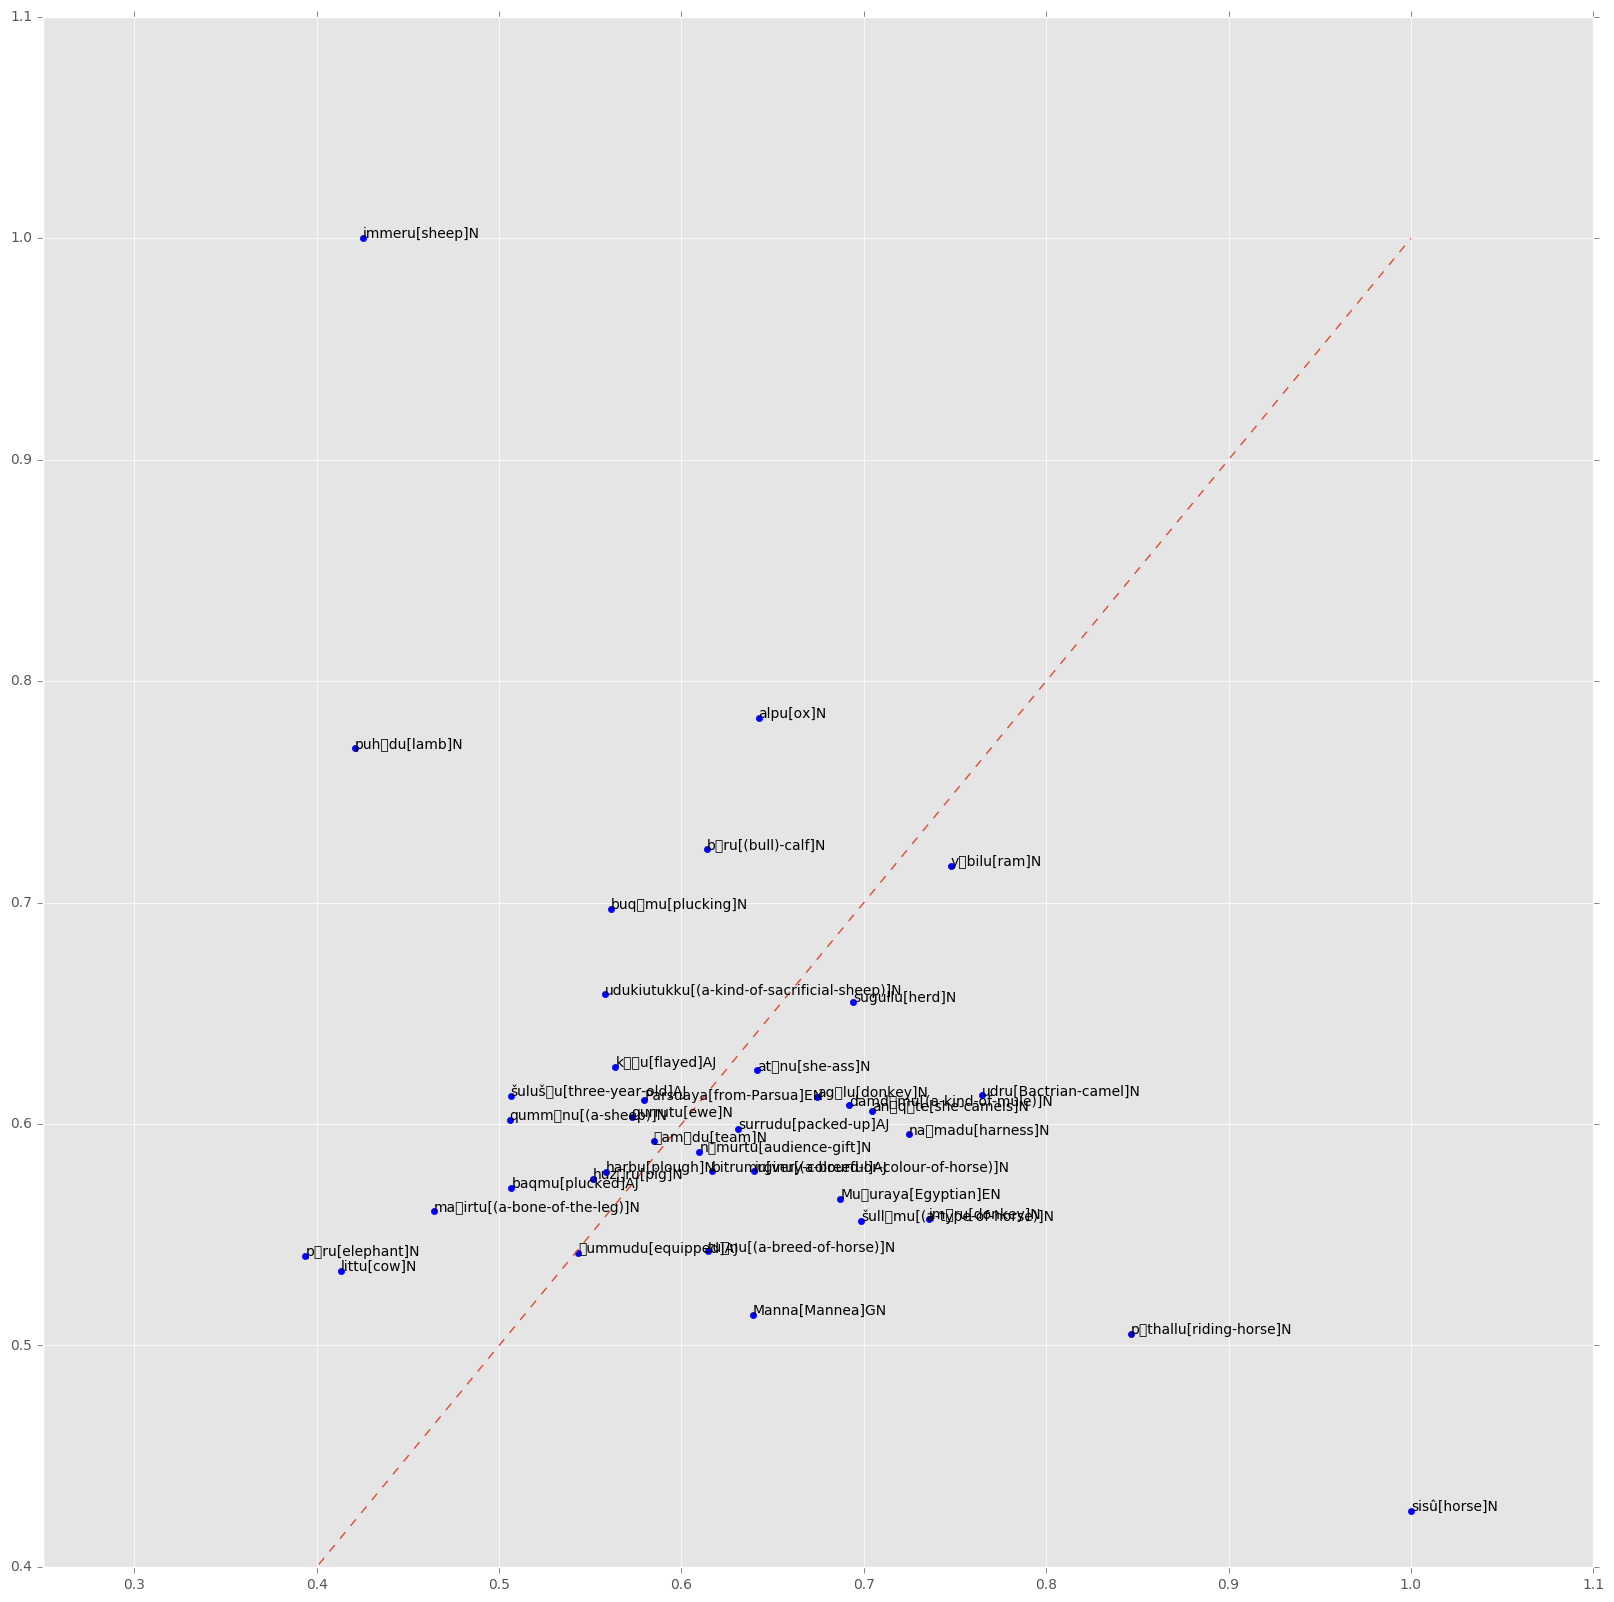

In [34]:
import matplotlib
matplotlib.rc('font', family="Times New Roman")
_, ax = plt.subplots(figsize=(20,20))
ax.scatter(x, y, alpha=1, color='b')
for i in range(len(animals)):
    ax.annotate(animals[i], (x[i], y[i]))
ax.set_xlim(.25, 1.1)
ax.set_ylim(.4, 1.1)
plt.plot([0, 1], [0, 1], linestyle='--');

### Q. What kinds of semantic relationships exist in the diagram above?
####    Are there any words that seem out of place?

## 3. Saving/Loading Models

In [29]:
# Save current model for later use

model.wv.save_word2vec_format('../data/word2vec.oracc.txt')

In [30]:
# Load up models from disk

# Model trained on Eighteenth Century Collections Online corpus (~2500 texts)
# Made available by Ryan Heuser: http://ryanheuser.org/word-vectors-1/

ecco_model = gensim.models.Word2Vec.load_word2vec_format('../data/word2vec.ECCO-TCP.txt')

In [31]:
# Can we get the currency sense of the word bank in Ryan Heuser's model?

ecco_model.most_similar(positive=['bank'], negative=['river'])

[('currency', 0.36714255809783936),
 ('suit', 0.35922902822494507),
 ('stamp', 0.3582037687301636),
 ('promissory', 0.35605305433273315),
 ('pension', 0.35183221101760864),
 ('blank', 0.3518177568912506),
 ('payable', 0.34270501136779785),
 ('mortality', 0.34262457489967346),
 ('weekly', 0.3408060669898987),
 ('weal', 0.3309359848499298)]

In [35]:
## EX. Heuser's blog post explores an analogy in eighteenth-century thought that
##     RICHES are to VIRTUE what LEARNING is to GENIUS.
## Reproduce this analogy using his trained word2vec model

##  Q. How might we compare word2vec models more generally?

ecco_model.most_similar(positive=['virtue', 'learning'], negative=['riches'])

[('piety', 0.7372761368751526),
 ('morality', 0.7266900539398193),
 ('science', 0.6974709630012512),
 ('prudence', 0.6855395436286926),
 ('philosophy', 0.683079183101654),
 ('wisdom', 0.6511392593383789),
 ('genius', 0.6505820155143738),
 ('humanity', 0.640283465385437),
 ('modesty', 0.6369403004646301),
 ('morals', 0.6340599060058594)]

# 4. Open Questions
At this point, we have seen a number of mathemetical operations that we may use to explore word2vec's word embeddings. These enable us to answer a set of new, interesting questions dealing with semantics, yet there are many other questions that remain unanswered.

For example:
<ol>
<li>How to compare word usages in different texts (within the same model)?</li>
<li>How to compare word meanings in different models? compare whole models?</li>
<li>What about the space “in between” words?</li>
<li>Do we agree with the Distributional Hypothesis that words with the same contexts share their meanings?</li>
<ol><li>If not, then what information do we think is encoded in a word’s context?</li></ol>
<li>What good, humanistic research questions do analogies shed light on?</li>
<ol><li>shades of meaning?</li><li>context similarity?</li></ol>
</ol>

With the time remaining, play around with either of these two word2vec models, or begin to implement it on your own corpus.